In [1]:
import librosa
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

import tensorflow as tf
 
%matplotlib inline
 
audio_path = '4_3273.wav'


In [2]:
y, sr = librosa.load(audio_path)

In [3]:
IPython.display.Audio(data=y, rate=sr)

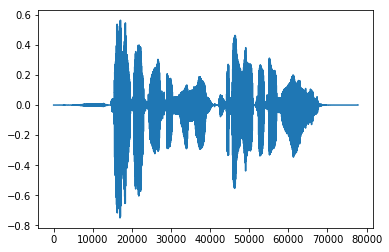

In [4]:
plt.figure()
plt.plot(y)

In [5]:
time_duration = int(librosa.get_duration(y=y, sr=sr) * 1000)
data_length = y.shape[0]
print("time duration: " + str(time_duration) + " ms")
print("sampling rate: " + str(sr))
print("data length: " + str(data_length))

time duration: 3529 ms
sampling rate: 22050
data length: 77824


In [77]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import nengo
from nengo.dists import Uniform

from nengo.processes import WhiteSignal
 
model = nengo.Network(label='Many Neurons')

In [89]:
def voice_input(t):
    ms = t * 1000 + 1000
    voice = y[int((data_length / time_duration) * int(ms))]
    return voice

In [90]:
with model:
    voice = nengo.Node(voice_input, size_out=1)
    A = nengo.Ensemble(80, dimensions=1)
    nengo.Connection(voice, A)
    
    p = nengo.Probe(A, synapse=0.01)
    inp_p = nengo.Probe(voice)
    spike_p = nengo.Probe(A.neurons)
    voltage_p = nengo.Probe(A.neurons, 'voltage')

In [91]:
#with nengo.Simulator(model) as sim: # this is the only line that changes
#    plt.figure()
#    plt.plot(*nengo.utils.ensemble.tuning_curves(A, sim))
#    plt.xlabel("input value")
#    plt.ylabel("firing rate")
#    plt.title(str(nengo.LIF()))
#    sim.run(3)

In [100]:
print(int(time_duration-1) / 1000)
with nengo.Simulator(model) as sim:
    #sim.run(int(time_duration-1) / 1000)
    sim.run(0.1)

3.528


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

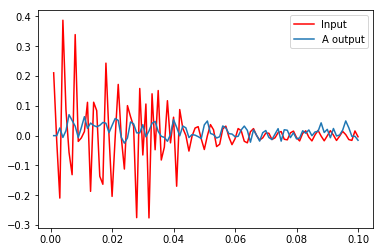

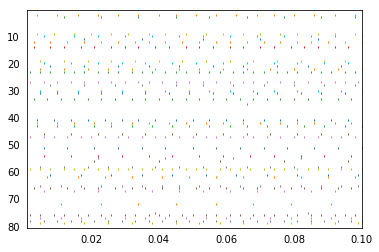

In [101]:
from nengo.utils.matplotlib import rasterplot
 
plt.figure()
plt.plot(sim.trange(), sim.data[inp_p], 'r', label="Input")
plt.plot(sim.trange(), sim.data[p], label="A output")
#plt.xlim(0, 5)
plt.legend()
 
plt.figure()
rasterplot(sim.trange(), sim.data[spike_p])
#plt.xlim(0, 5);


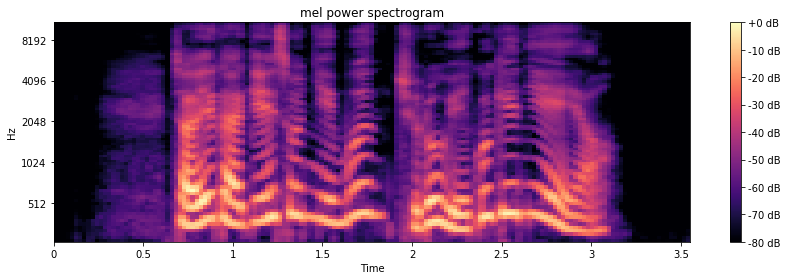

In [12]:
nMels = 80
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=nMels) 
 
log_S = librosa.logamplitude(S, ref_power=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()


In [90]:
def half_normalize(S):
    return (S - S.min()/2) / (-S.min()/2)

def simple_normalize(S):
    return (S - S.min()) / (-S.min())

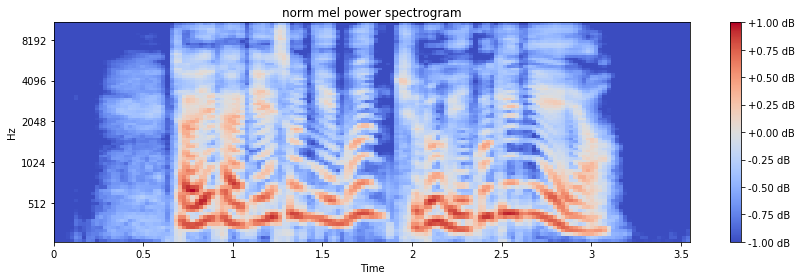

In [91]:
norm_S = half_normalize(log_S)
#norm_S = simple_normalize(log_S)
 
plt.figure(figsize=(12, 4))
librosa.display.specshow(norm_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('norm mel power spectrogram')
plt.colorbar(format='%+0.2f dB')
plt.tight_layout()
plt.show()

In [92]:
transposed_norm_S = norm_S.transpose()
frame_size = int(time_duration/transposed_norm_S.shape[0])+1

print(transposed_norm_S.shape)

(153, 80)


In [93]:
def voice_input(t):
    ms = int(t * 1000)
    frame_num = int(ms / frame_size)
    voice = transposed_norm_S[frame_num]
    return voice

In [94]:
neuron_number = 80
with nengo.Network() as net:
    voice = nengo.Node(output=voice_input)
    neuronsEns = nengo.Ensemble(neuron_number, dimensions=neuron_number, max_rates=([100] * neuron_number))
    
    nengo.Connection(voice, neuronsEns, synapse=0.01)
    
    voice_probe = nengo.Probe(voice)
    neurons_probe = nengo.Probe(neuronsEns, synapse=0.01)
    spike_probe = nengo.Probe(neuronsEns.neurons)
    voltage_probe = nengo.Probe(neuronsEns.neurons, 'voltage')
    

In [95]:
with nengo.Simulator(net) as sim:
    sim.run(int(time_duration) / 1000)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

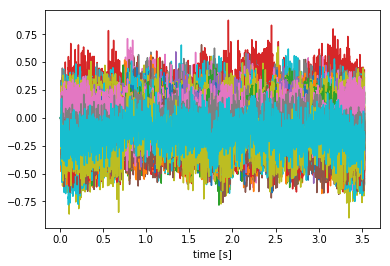

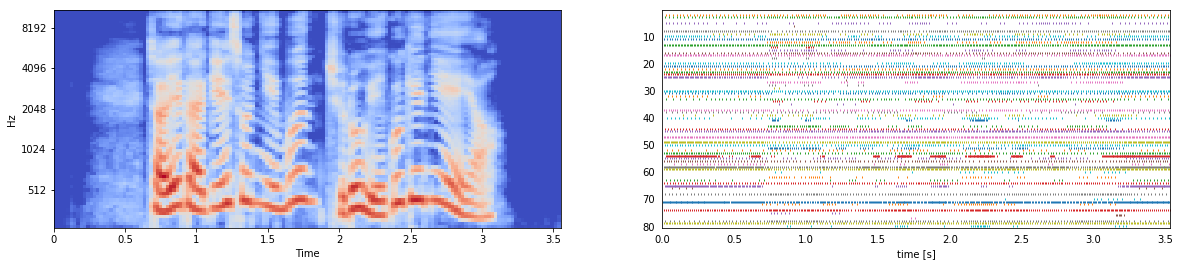

In [96]:
plt.figure()
plt.plot(sim.trange(), sim.data[neurons_probe])
plt.xlabel('time [s]');

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(norm_S, sr=sr, x_axis='time', y_axis='mel')

plt.subplot(1, 2, 2)
rasterplot(sim.trange(), sim.data[spike_probe])
plt.xlabel('time [s]');